In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qibo.gates import M, X
from qibo.models.circuit import Circuit

from qililab import Experiment, ExperimentOptions, build_platform
from qililab.pulse import Pulse, PulseEvent
from qililab.pulse.pulse_schedule import PulseSchedule
from qililab.pulse.pulse_shape.gaussian import Gaussian

In [2]:
fname = os.path.abspath("")
os.environ["RUNCARDS"] = str(Path(fname) / "runcards")
os.environ["DATA"] = str(Path(fname) / "data")

In [3]:
# PARAMS

# qubit parameters in runcard
dimension = 10  # used for results, same as in runcard

amp = 1e-18
tmax = 200  # ns
tstep = 1e-2  # ns, same as runcard
# freq not defined -> qubit frequency is used
freq = 13066127893.759731

sigma = 0.12 * tmax
num_sigmas = tmax / sigma

[qililab] [0.16.1|INFO|2023-06-02 10:12:06]: Building platform
INFO:qililab.config.config:Building platform
[qililab] [0.16.1|INFO|2023-06-02 10:12:07]: Connected to the instruments
INFO:qililab.config.config:Connected to the instruments
[qililab] [0.16.1|INFO|2023-06-02 10:12:07]: Initial setup applied to the instruments
INFO:qililab.config.config:Initial setup applied to the instruments
[qililab] [0.16.1|INFO|2023-06-02 10:12:07]: Instruments turned on
INFO:qililab.config.config:Instruments turned on


20000


[qililab] [0.16.1|INFO|2023-06-02 10:12:21]: Instruments turned off
INFO:qililab.config.config:Instruments turned off
[qililab] [0.16.1|INFO|2023-06-02 10:12:21]: Disconnected from instruments
INFO:qililab.config.config:Disconnected from instruments


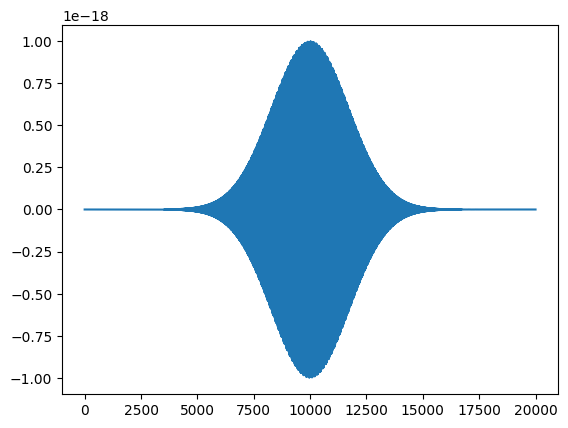

In [4]:
# RUN CALCULATION
platform = build_platform(name="flux_qubit_simulator")

qubit = platform.chip.get_port_nodes(port_id=0)[0]

gaussian = Gaussian(num_sigmas=num_sigmas)
pulse_event = PulseEvent(
    Pulse(amplitude=amp, duration=tmax, phase=0, frequency=freq, pulse_shape=gaussian), start_time=0
)

pulse_schedule = PulseSchedule()
pulse_schedule.add_event(pulse_event, port=0)

experiment = Experiment(platform=platform, pulse_schedules=[pulse_schedule])
print(len(pulse_event.modulated_waveforms(resolution=0.01).i))
plt.plot(pulse_event.modulated_waveforms(resolution=0.01).i)

results = experiment.execute()

In [5]:
# RESULTS
result = results.results[0]

states = [result.psi0] + result.states
times = [0] + result.times


# Operators: populations
# Hilbert space contains only the qubit in its eigenbasis
init0 = qt.fock_dm(dimensions=dimension, n=0)
init1 = qt.fock_dm(dimensions=dimension, n=1)

probs0_l = []
probs1_l = []
for state in states:
    probs0_l.append(qt.expect(init0, state))
    probs1_l.append(qt.expect(init1, state))

probs0 = np.array(probs0_l)
probs1 = np.array(probs1_l)

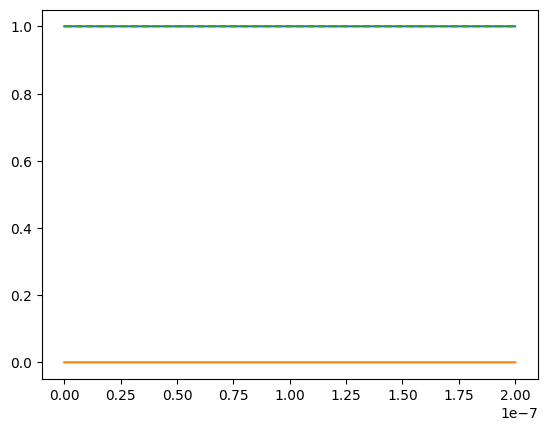

In [6]:
# PLOT
plt.figure()
plt.plot(times, probs0)
plt.plot(times, probs1)
plt.plot(times, probs0 + probs1, "--")

20000


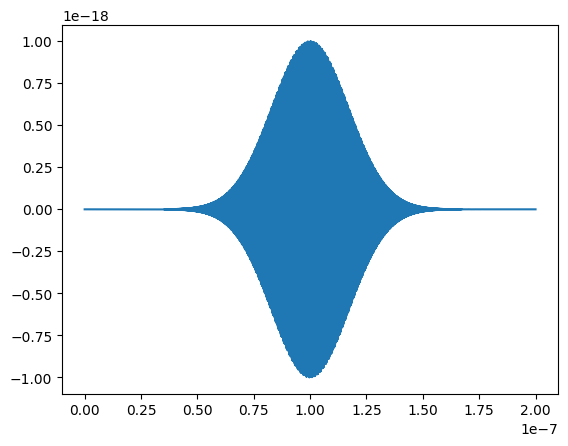

In [7]:
# Sanity check: plot pulse

ssc = experiment.execution_manager.buses[0].system_control
waveform = ssc._evo.waveforms[0]

print(len(waveform))
plt.figure()
plt.plot(times[:-1], waveform)